# Overview

This notebook will perform the following tasks:

- define wrapper function to invoke LIDIA model for interactive inference
- analyze de-noise performance of LIDIA model with
  - synthetic data

## Wrapper for LIDIA

In [1]:
import sys
sys.path.append('../LIDIA-denoiser/code')

import torch
import numpy as np
import matplotlib.pyplot as plt

from modules import (
    ArchitectureOptions,
    NonLocalDenoiser,
)

from utils import (
    calc_padding,
    process_image,
    adapt_net,
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda')

In [2]:
class MockedOpt:
    def __init__(self):
        self.sigma = 50  # or any default/mock value you need
        self.seed = 8
        # self.in_path = 'images/brick_house/gray/test1_bw.png'
        # self.out_path = 'output/'
        self.save = False
        self.max_chunk = 40000
        self.cuda_retrain = False
        self.cuda_denoise = False
        self.plot = False
        self.block_w = 64
        self.train_batch_size = 4
        self.epoch_num = 5
        self.lr = 1e-3
        self.dset_stride = 32
        self.epochs_between_check = 5

# Create an instance of the mocked options
mocked_opt = MockedOpt()

In [3]:
def denoise_with_lidia(
        input_img: np.ndarray,
        sigma: int,
        self_adapt: bool=False,
    ) -> np.ndarray:
    """Wrapper for LIDIA denoiser.
    
    Parameters
    ----------
    input_img : np.ndarray
        Input image to be denoised.
    sigma : int
        Noise level, [15, 25, 50].
    self_adapt : bool, optional
        Whether to adapt the denoiser to the denoised image.
        Default is False.
        
    Returns
    -------
    np.ndarray
        Denoised image.

    NOTE
    ----
    This wrapper function is not optimized for production.
    It is adapted from LIDIA-denoiser/code/denoise_bw.py
    """
    # define the model
    arch_opt = ArchitectureOptions(rgb=False, small_network=False)
    opt = MockedOpt()  # use default
    # update the sigma
    opt.sigma = sigma
    pad_offs, total_pad = calc_padding(arch_opt)
    nl_denoiser = NonLocalDenoiser(pad_offs, arch_opt)
    nl_denoiser.cuda()
    # nl_denoiser.cpu()

    # load the weight
    model_file_path = f"../LIDIA-denoiser/models/model_state_sigma_{sigma}_bw.pt"
    model_state0 = torch.load(
        model_file_path,
        # map_location='cpu',
    )
    nl_denoiser.patch_denoise_net.load_state_dict(
        model_state0['state_dict']
    )

    # process the image
    rst_img = process_image(
        nl_denoiser,
        torch.from_numpy(input_img).to(device),
        opt.max_chunk,
    ).cpu().numpy()

    # adapt the net
    if self_adapt:
        rst_img = torch.from_numpy(rst_img).to(device)
        nl_denoiser = adapt_net(nl_denoiser, opt, total_pad, rst_img)
        nl_denoiser.cuda()
        rst_img = process_image(
            nl_denoiser,
            torch.from_numpy(input_img).to(device),
            opt.max_chunk,
        ).cpu().numpy()

    return rst_img

## Case study: Shepp-Logan phantom 2D

In [4]:
import tomopy
from ntabpy.evaluator import tomo_round_trip_2d
from ntabpy.metric import calc_psnr

In [5]:
image_size = 512
phantom = tomopy.misc.phantom.shepp2d(size=image_size)

Input Image:  0.0 255.0
Sinogram:  1e-08 1.0
Reconstruction:  -0.010274865 0.0120970765
Gain Error:  0.61322176 1.405838
Reconstruction of Gain Error:  -0.017738635 0.036787685


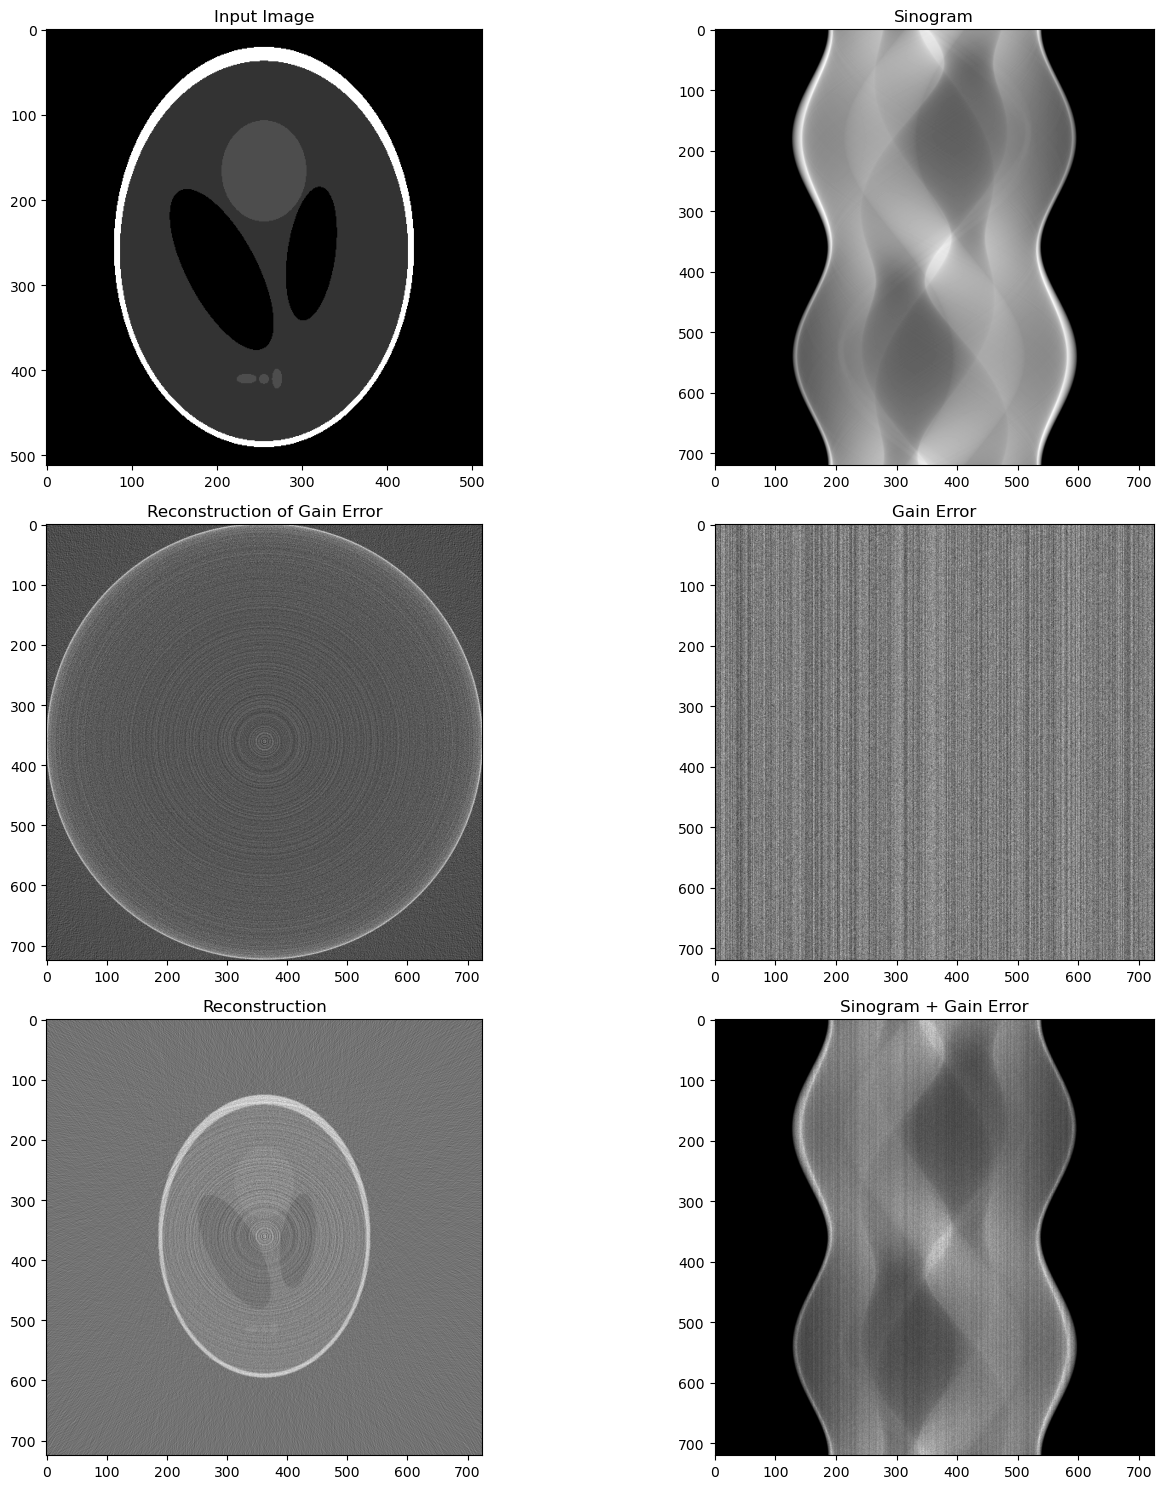

In [6]:
sino_noisy, recon_noisy, sino_gain, recon_gain, sino_org = tomo_round_trip_2d(
    phantom[0],
    scan_step=0.5,
    detector_gain_range=(0.9, 1.1),
    detector_gain_error=0.07,
    show_plot=True,
)

In [7]:
calc_psnr(sino_org, sino_noisy)

-77.6565159980986

perform de-noising with bm3d

In [8]:
import bm3d_streak_removal as bm3dsr

In [9]:
sion_bm3d_attenuated = bm3dsr.extreme_streak_attenuation(
    data=sino_noisy,
    extreme_streak_iterations=3,
    extreme_detect_lambda=4.0,
    extreme_detect_size=9,
    extreme_replace_size=2,
)

Median filtering, iteration 0
Median filtering, iteration 1
Median filtering, iteration 2


In [10]:
sino_bm3d = bm3dsr.multiscale_streak_removal(
    data=sion_bm3d_attenuated,
    max_bin_iter_horizontal=0,
    bin_vertical=0,
    filter_strength=1.0,
    use_slices=True,
    slice_sizes=None,
    slice_step_sizes=None,
    denoise_indices=None,
)

Denoising sinogram 0
k: 0


In [11]:
sion_bm3d_attenuated = sion_bm3d_attenuated[:, 0, :]
sino_bm3d = sino_bm3d[:, 0, :]

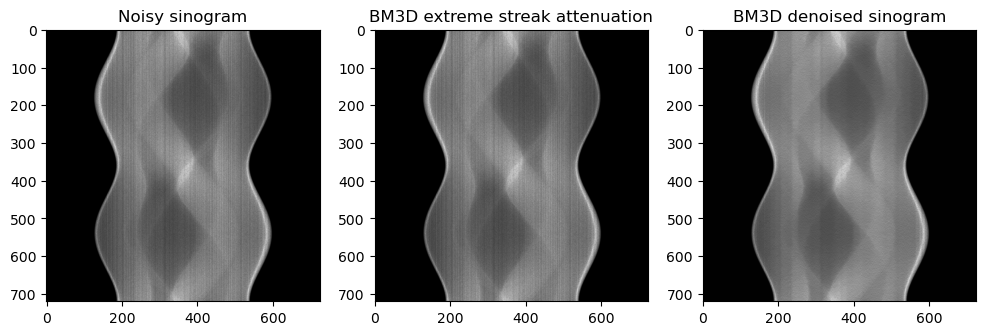

In [12]:
# visualize side by side
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(sino_noisy, cmap='gray')
axs[0].set_title('Noisy sinogram')
axs[1].imshow(sion_bm3d_attenuated, cmap='gray')
axs[1].set_title('BM3D extreme streak attenuation')
axs[2].imshow(sino_bm3d, cmap='gray')
axs[2].set_title('BM3D denoised sinogram')
plt.show()

In [13]:
calc_psnr(sino_bm3d, sino_org)

-77.65651632211986

perform denoise with LIDIA

In [14]:
# reshape the image to add a batch dim and a channel dim
sino_noisy_reshaped = np.expand_dims(sino_noisy, axis=0)
sino_noisy_reshaped = np.expand_dims(sino_noisy_reshaped, axis=0)
print(sino_noisy_reshaped.shape)

(1, 1, 720, 725)


use smallest sigma

In [15]:
sino_lidia_sigma15 = denoise_with_lidia(sino_noisy_reshaped, sigma=15)

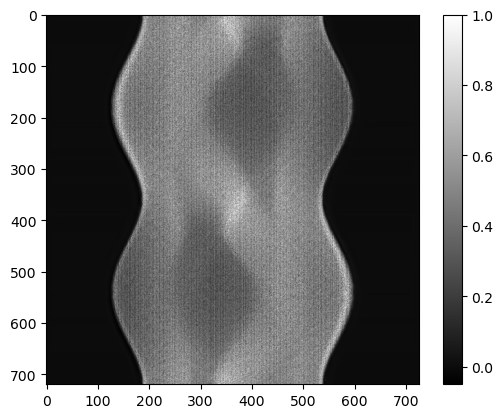

In [16]:
plt.imshow(sino_lidia_sigma15[0, 0, :, :], cmap='gray')
plt.colorbar()
plt.show()

In [17]:
sino_lidia_sigma15_adapt = denoise_with_lidia(sino_noisy_reshaped, sigma=15, self_adapt=True)

Training epoch 1 of 5
Training epoch 2 of 5
Training epoch 3 of 5
Training epoch 4 of 5
Training epoch 5 of 5


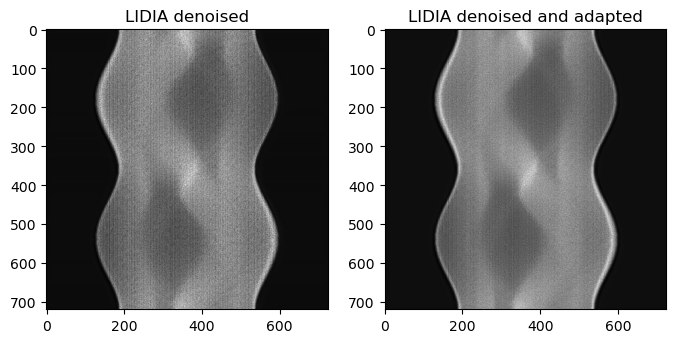

In [18]:
# visualize side by side
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(sino_lidia_sigma15[0, 0, :, :], cmap='gray')
axs[0].set_title('LIDIA denoised')
axs[1].imshow(sino_lidia_sigma15_adapt[0, 0, :, :], cmap='gray')
axs[1].set_title('LIDIA denoised and adapted')
plt.show()

In [19]:
calc_psnr(sino_org, sino_lidia_sigma15[0, 0, :, :]), calc_psnr(sino_org, sino_lidia_sigma15_adapt[0, 0, :, :])

(-77.65651689205, -77.6565159980986)

raise sigma to 25

In [20]:
sino_lidia_sigma25 = denoise_with_lidia(sino_noisy_reshaped, sigma=25)

In [21]:
sino_lidia_sigma25_adapt = denoise_with_lidia(sino_noisy_reshaped, sigma=25, self_adapt=True)

Training epoch 1 of 5
Training epoch 2 of 5
Training epoch 3 of 5
Training epoch 4 of 5
Training epoch 5 of 5


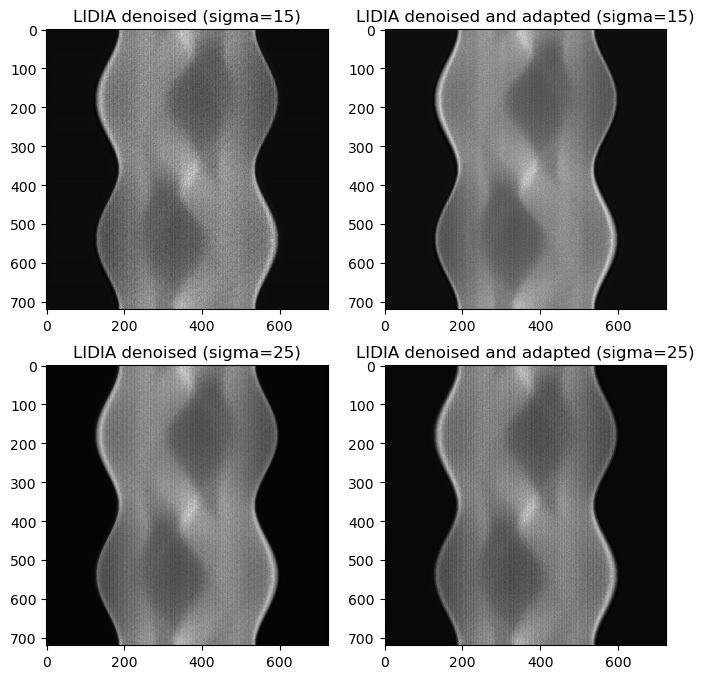

In [22]:
# visualize everyone side by side
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs[0, 0].imshow(sino_lidia_sigma15[0, 0, :, :], cmap='gray')
axs[0, 0].set_title('LIDIA denoised (sigma=15)')
axs[0, 1].imshow(sino_lidia_sigma15_adapt[0, 0, :, :], cmap='gray')
axs[0, 1].set_title('LIDIA denoised and adapted (sigma=15)')
axs[1, 0].imshow(sino_lidia_sigma25[0, 0, :, :], cmap='gray')
axs[1, 0].set_title('LIDIA denoised (sigma=25)')
axs[1, 1].imshow(sino_lidia_sigma25_adapt[0, 0, :, :], cmap='gray')
axs[1, 1].set_title('LIDIA denoised and adapted (sigma=25)')
plt.show()

raise again to 50

In [23]:
sino_lidia_sigma50 = denoise_with_lidia(sino_noisy_reshaped, sigma=50)

In [24]:
sino_lidia_sigma50_adapt = denoise_with_lidia(sino_noisy_reshaped, sigma=50, self_adapt=True)

Training epoch 1 of 5
Training epoch 2 of 5
Training epoch 3 of 5
Training epoch 4 of 5
Training epoch 5 of 5


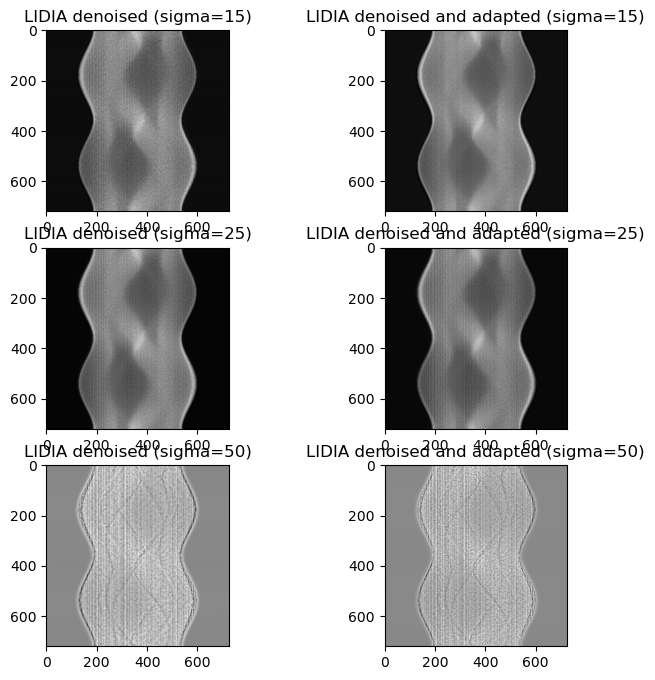

In [25]:
# visualize everyone side by side
fig, axs = plt.subplots(3, 2, figsize=(8, 8))
axs[0, 0].imshow(sino_lidia_sigma15[0, 0, :, :], cmap='gray')
axs[0, 0].set_title('LIDIA denoised (sigma=15)')
axs[0, 1].imshow(sino_lidia_sigma15_adapt[0, 0, :, :], cmap='gray')
axs[0, 1].set_title('LIDIA denoised and adapted (sigma=15)')
axs[1, 0].imshow(sino_lidia_sigma25[0, 0, :, :], cmap='gray')
axs[1, 0].set_title('LIDIA denoised (sigma=25)')
axs[1, 1].imshow(sino_lidia_sigma25_adapt[0, 0, :, :], cmap='gray')
axs[1, 1].set_title('LIDIA denoised and adapted (sigma=25)')
axs[2, 0].imshow(sino_lidia_sigma50[0, 0, :, :], cmap='gray')
axs[2, 0].set_title('LIDIA denoised (sigma=50)')
axs[2, 1].imshow(sino_lidia_sigma50_adapt[0, 0, :, :], cmap='gray')
axs[2, 1].set_title('LIDIA denoised and adapted (sigma=50)')
plt.show()

Compare with ground truth, bm3d and LIDIA

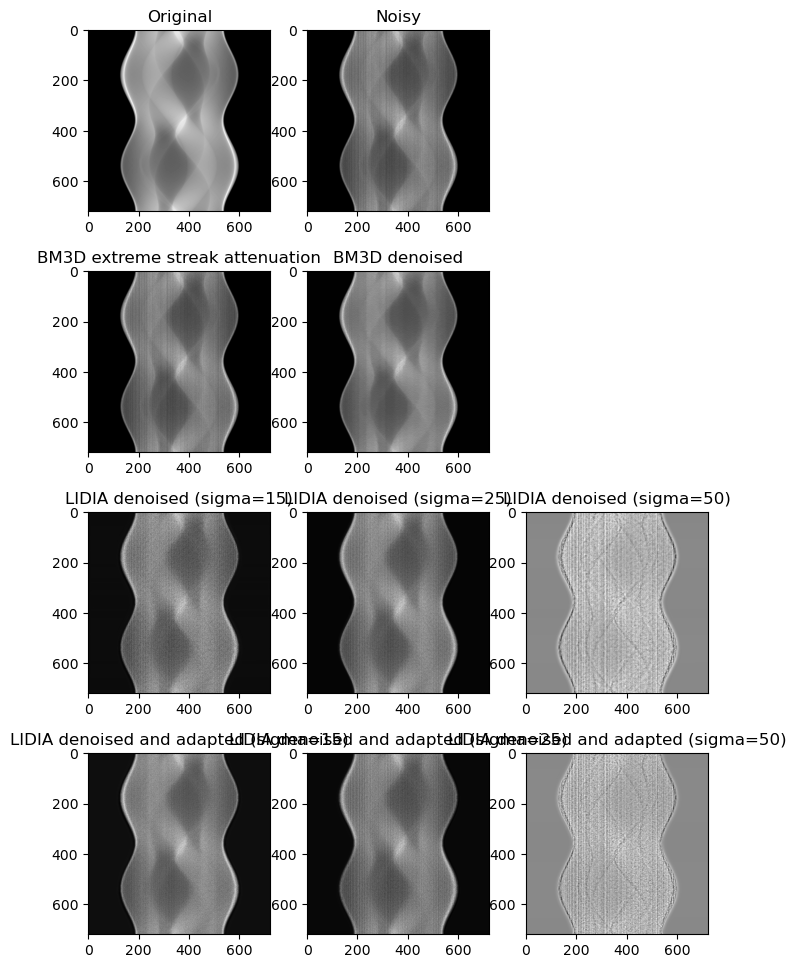

In [36]:
# visualize side by side
# org, noisy
# sion_bm3d_attenuated, bm3d
# lidia_15, lidia_25, lidia_50
# lidia_15_adapt, lidia_25_adapt, lidia_50_adapt
fig, axs = plt.subplots(4, 3, figsize=(8, 12))
axs[0, 0].imshow(sino_org, cmap='gray')
axs[0, 0].set_title('Original')
axs[0, 1].imshow(sino_noisy, cmap='gray')
axs[0, 1].set_title('Noisy')
axs[1, 0].imshow(sion_bm3d_attenuated, cmap='gray')
axs[1, 0].set_title('BM3D extreme streak attenuation')
axs[1, 1].imshow(sino_bm3d, cmap='gray')
axs[1, 1].set_title('BM3D denoised')
axs[2, 0].imshow(sino_lidia_sigma15[0, 0, :, :], cmap='gray')
axs[2, 0].set_title('LIDIA denoised (sigma=15)')
axs[2, 1].imshow(sino_lidia_sigma25[0, 0, :, :], cmap='gray')
axs[2, 1].set_title('LIDIA denoised (sigma=25)')
axs[2, 2].imshow(sino_lidia_sigma50[0, 0, :, :], cmap='gray')
axs[2, 2].set_title('LIDIA denoised (sigma=50)')
axs[3, 0].imshow(sino_lidia_sigma15_adapt[0, 0, :, :], cmap='gray')
axs[3, 0].set_title('LIDIA denoised and adapted (sigma=15)')
axs[3, 1].imshow(sino_lidia_sigma25_adapt[0, 0, :, :], cmap='gray')
axs[3, 1].set_title('LIDIA denoised and adapted (sigma=25)')
axs[3, 2].imshow(sino_lidia_sigma50_adapt[0, 0, :, :], cmap='gray')
axs[3, 2].set_title('LIDIA denoised and adapted (sigma=50)')
# remove the empty subplot
fig.delaxes(axs[0, 2])
fig.delaxes(axs[1, 2])

plt.show()

Try to reconstruct to see the ring artifact

In [27]:
thetas_deg = np.arange(-180, 180, 0.5)

In [28]:
from ntabpy.evaluator import recon_from_sinogram

In [29]:
recon_bm3d = recon_from_sinogram(
    sino_bm3d,
    thetas_deg,
)

In [30]:
recon_lidia_sigma15 = recon_from_sinogram(
    sino_lidia_sigma15[0, 0, :, :],
    thetas_deg,
)

recon_lidia_sigma15_adapt = recon_from_sinogram(
    sino_lidia_sigma15_adapt[0, 0, :, :],
    thetas_deg,
)

In [31]:
recon_lidia_sigma25 = recon_from_sinogram(
    sino_lidia_sigma25[0, 0, :, :],
    thetas_deg,
)

recon_lidia_sigma25_adapt = recon_from_sinogram(
    sino_lidia_sigma25_adapt[0, 0, :, :],
    thetas_deg,
)

In [32]:
recon_lidia_sigma50 = recon_from_sinogram(
    sino_lidia_sigma50[0, 0, :, :],
    thetas_deg,
)

recon_lidia_sigma50_adapt = recon_from_sinogram(
    sino_lidia_sigma50_adapt[0, 0, :, :],
    thetas_deg,
)

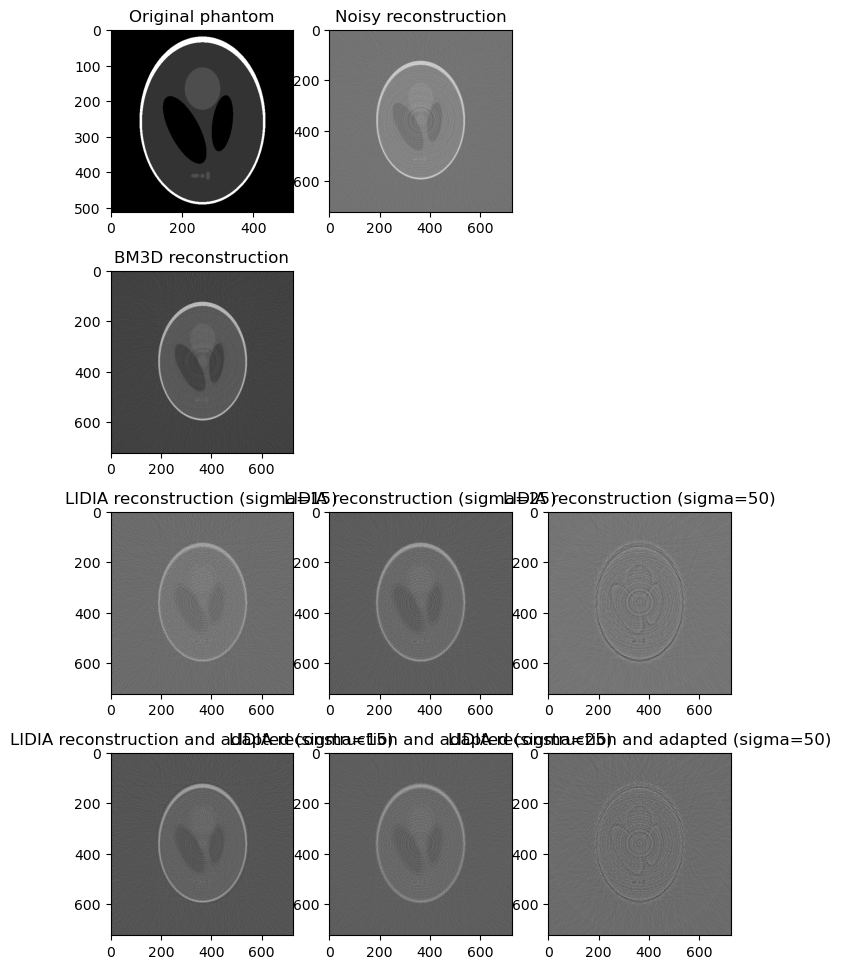

In [37]:
# visualize side by side
# phantom, recon_noisy
# recon_bm3d
# recon_lidia_sigma15, recon_lidia_sigma25, recon_lidia_sigma50
# recon_lidia_sigma15_adapt, recon_lidia_sigma25_adapt, recon_lidia_sigma50_adapt
fig, axs = plt.subplots(4, 3, figsize=(8, 12))
axs[0, 0].imshow(phantom[0], cmap='gray')
axs[0, 0].set_title('Original phantom')
axs[0, 1].imshow(recon_noisy, cmap='gray')
axs[0, 1].set_title('Noisy reconstruction')
axs[1, 0].imshow(recon_bm3d, cmap='gray')
axs[1, 0].set_title('BM3D reconstruction')
axs[2, 0].imshow(recon_lidia_sigma15, cmap='gray')
axs[2, 0].set_title('LIDIA reconstruction (sigma=15)')
axs[2, 1].imshow(recon_lidia_sigma25, cmap='gray')
axs[2, 1].set_title('LIDIA reconstruction (sigma=25)')
axs[2, 2].imshow(recon_lidia_sigma50, cmap='gray')
axs[2, 2].set_title('LIDIA reconstruction (sigma=50)')
axs[3, 0].imshow(recon_lidia_sigma15_adapt, cmap='gray')
axs[3, 0].set_title('LIDIA reconstruction and adapted (sigma=15)')
axs[3, 1].imshow(recon_lidia_sigma25_adapt, cmap='gray')
axs[3, 1].set_title('LIDIA reconstruction and adapted (sigma=25)')
axs[3, 2].imshow(recon_lidia_sigma50_adapt, cmap='gray')
axs[3, 2].set_title('LIDIA reconstruction and adapted (sigma=50)')
# remove the empty subplot
fig.delaxes(axs[0, 2])
fig.delaxes(axs[1, 1])
fig.delaxes(axs[1, 2])
plt.show()